# Assignment 2
## Batch Normalization

Batch normalization 的想法比较简单：

当机器学习方法的输入数据如果满足零均值和特征单位方差不相关时，学习的效果往往较好。在深度模型中，我们可以通过数据的预处理来实现上面两个特点，但是随着网络层数的增加，在后面一些层我们将不再保证传递的数据具有这样的特性。于是，为了克服这样的问题就出现了 BN 层

在训练时，BN 层使用一小批数据来估计每个特征的平均值和标准偏差。然后，使用这些估计的平均值和标准偏差对小批量数据的特征进行中心化和标准化。在训练期间，保存这些平均值和标准方差的运行平均值，在测试时，将这些运行平均值用于中心化和规范化特征

这种标准化策略可能会降低网络的代表性，因为有时某些层的特征不是零均值或单位方差可能是最佳的。为此，批处理规范化层包括每个特征维度的可学习移位和缩放参数

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [4]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## Batch normalization: Forward

In [6]:
# 测试一下训练时 BN 的前向传播，我们使用两层神经网络
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('means:', a.mean(axis = 0))
print('stds:', a.std(axis = 0))
print('\n')

# 期望应该接近于 0，标准差接近于 1
print('After batch normalization (gamma = 1, beta = 0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('mean:', a_norm.mean(axis = 0))
print('std:', a_norm.std(axis = 0))
print('\n')

# 经过 BN 处理后期望应该接近于 beta，标准差接近于 gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta')
print('means:', a_norm.mean(axis = 0))
print('stds:', a_norm.std(axis = 0))

Before batch normalization:
means: [  3.69985167 -11.27405364  -5.39811098]
stds: [30.78452093 34.51967733 37.57915765]


After batch normalization (gamma = 1, beta = 0)
mean: [-3.60822483e-17  3.28626015e-16  1.94289029e-18]
std: [0.99999999 1.         1.        ]


After batch normalization (nontrivial gamma, beta
means: [11. 12. 13.]
stds: [0.99999999 1.99999999 2.99999999]


In [11]:
# 测试一下测试时 BN 的前向传播
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# 期望应该接近于 0，标准差接近于 1，但是会比训练时的结果有明显的噪音
print('After batch normalization (test-time):')
print('means: ', a_norm.mean(axis=0))
print('stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
means:  [ 0.01291529  0.05588077 -0.17497396]
stds:  [0.99602856 1.03435275 1.10773039]


## Batch normalization: backward

In [14]:
# 测试一下 BN 的反向传播
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.8163377343104557e-09
dgamma error:  1.0545696883612364e-11
dbeta error:  1.6605582725069276e-11


## Batch Normalization: alternative backward

我们可以通过导数计算化简的方式推导出 batch norm 反向传播的表达式，在函数 batchnorm_backward_alt 中实现。两种反向传播计算的结果几乎相同，但是  batchnorm_backward_alt 实现应该更快一些

In [15]:
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  2.621871168058191e-12
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 2.00x


## FC Nets with Batch Normalization

In [21]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size = (N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2],
                              input_dim = D, 
                              num_classes = C, 
                              reg = reg,
                              weight_scale = 5e-2,
                              dtype = np.float64,
                              use_batchnorm = True)
    loss, grads = model.loss(X, y)
    print('Inital loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num= eval_numerical_gradient(f, model.params[name], verbose = False, h = 1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    
    if reg == 0: print('\n')

Running check with reg =  0
Inital loss:  2.4312951235734097
W1 relative error: 1.85e-04
W2 relative error: 4.69e-06
W3 relative error: 4.91e-10
b1 relative error: 4.44e-03
b2 relative error: 2.22e-03
b3 relative error: 8.53e-11
beta1 relative error: 7.09e-09
beta2 relative error: 3.00e-09
gamma1 relative error: 1.08e-08
gamma2 relative error: 2.75e-09


Running check with reg =  3.14
Inital loss:  7.139214609785039
W1 relative error: 1.07e-07
W2 relative error: 1.15e-04
W3 relative error: 4.98e-08
b1 relative error: 1.39e-09
b2 relative error: 1.11e-08
b3 relative error: 2.90e-10
beta1 relative error: 1.28e-07
beta2 relative error: 2.50e-08
gamma1 relative error: 1.41e-07
gamma2 relative error: 2.04e-08


## Batchnorm for deep networks

In [27]:
# 我们简单训练一个 6 层的神经网络，数据集大小选为 1k
# 比较一下又 BN 和没有 BN 网络表现的不同
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {'X_train': data['X_train'][:num_train],
              'y_train': data['y_train'][:num_train],
              'X_val': data['X_val'],
              'y_val': data['y_val'],}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale = weight_scale, use_batchnorm = True)
model = FullyConnectedNet(hidden_dims, weight_scale = weight_scale, use_batchnorm = False)

bn_solver = Solver(bn_model, 
                   small_data,
                   num_epochs=10, batch_size=50,
                   update_rule='adam',
                   optim_config={'learning_rate': 1e-3,},
                   verbose=True, 
                   print_every=200)
bn_solver.train()

solver = Solver(model, 
                small_data,
                num_epochs=10, 
                batch_size=50,
                update_rule='adam',
                optim_config={'learning_rate': 1e-3,},
                verbose=True, 
                print_every=200)
solver.train()

(Iteration 1 / 200) loss: 2.286003
(Epoch 0 / 10) train acc: 0.125000; val_acc: 0.095000
(Epoch 1 / 10) train acc: 0.304000; val_acc: 0.236000
(Epoch 2 / 10) train acc: 0.436000; val_acc: 0.303000
(Epoch 3 / 10) train acc: 0.491000; val_acc: 0.316000
(Epoch 4 / 10) train acc: 0.575000; val_acc: 0.319000
(Epoch 5 / 10) train acc: 0.626000; val_acc: 0.336000
(Epoch 6 / 10) train acc: 0.689000; val_acc: 0.343000
(Epoch 7 / 10) train acc: 0.714000; val_acc: 0.335000
(Epoch 8 / 10) train acc: 0.733000; val_acc: 0.328000
(Epoch 9 / 10) train acc: 0.793000; val_acc: 0.339000
(Epoch 10 / 10) train acc: 0.812000; val_acc: 0.342000
(Iteration 1 / 200) loss: 2.302744
(Epoch 0 / 10) train acc: 0.120000; val_acc: 0.140000
(Epoch 1 / 10) train acc: 0.233000; val_acc: 0.203000
(Epoch 2 / 10) train acc: 0.292000; val_acc: 0.237000
(Epoch 3 / 10) train acc: 0.242000; val_acc: 0.202000
(Epoch 4 / 10) train acc: 0.303000; val_acc: 0.240000
(Epoch 5 / 10) train acc: 0.337000; val_acc: 0.264000
(Epoch 6 / 

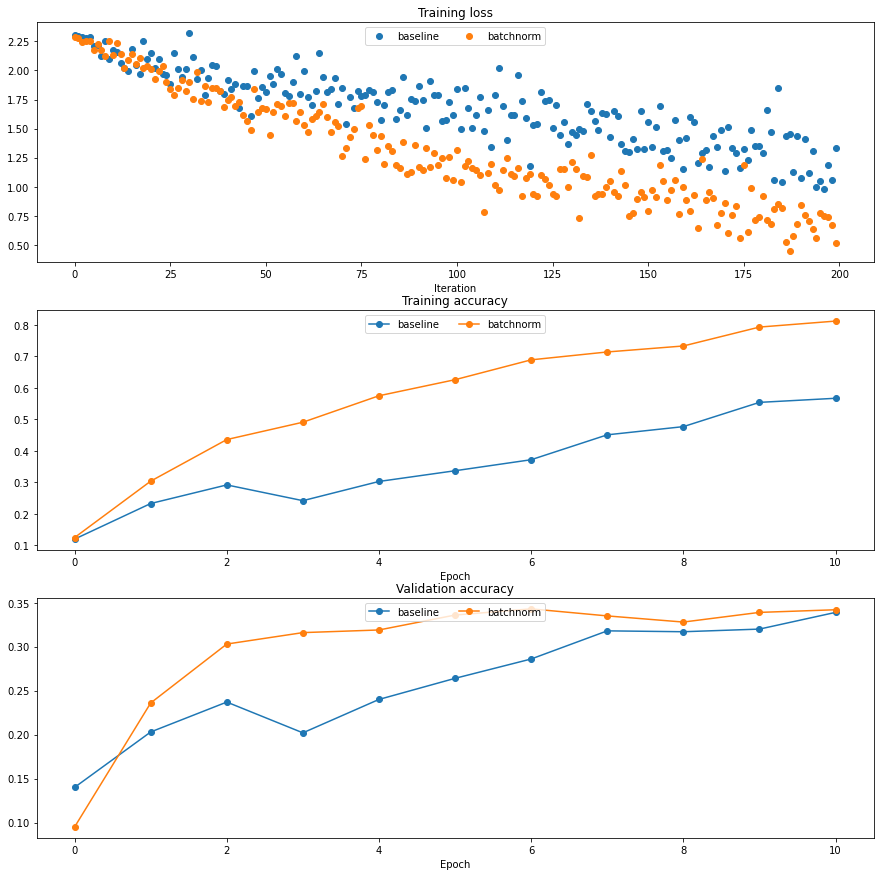

In [28]:

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label='baseline')
plt.plot(bn_solver.loss_history, 'o', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Batch normalization and initialization

现在我们通过一个试验来说明 batch norm 和权重初始化之间的联系

在第一个 cell 中，我们先训练一个 8 层的神经网络，分带或不带 batch norm 两种，我们用不同的范围进行权重初始化

在第二个 cell 中，我们将展现训练集准确率、验证集准确率、训练损失等可视化的结果

In [29]:
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {'X_train': data['X_train'][:num_train],
              'y_train': data['y_train'][:num_train],
              'X_val': data['X_val'],
              'y_val': data['y_val'],}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
  print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
  bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
  model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

  bn_solver = Solver(bn_model,
                     small_data,
                     num_epochs=10, 
                     batch_size=50,
                     update_rule='adam',
                     optim_config={'learning_rate': 1e-3,},
                     verbose=False, 
                     print_every=200)
  bn_solver.train()
  bn_solvers[weight_scale] = bn_solver

  solver = Solver(model, 
                  small_data,
                  num_epochs=10,
                  batch_size=50,
                  update_rule='adam',
                  optim_config={'learning_rate': 1e-3,},
                  verbose=False, 
                  print_every=200)
  solver.train()
  solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


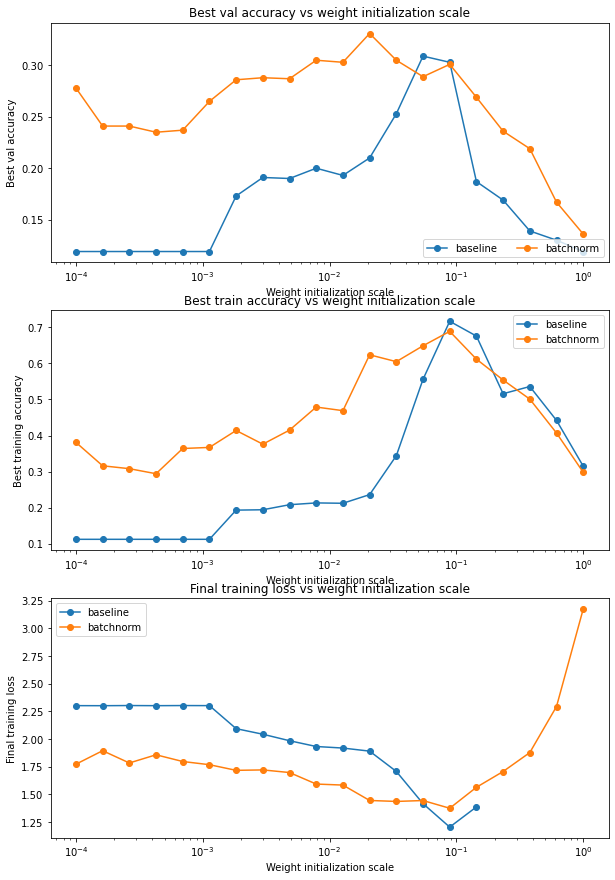

In [30]:
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(solvers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))
  
    best_val_accs.append(max(solvers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))
  
    final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()

总结该实验的结果，并解释为什么会出现这样子的结果

答：

该实验表明，带 batch norm 的模型
- 对于很差的初始化也是十分鲁棒的，即使在一个很差的初始化下也可以得到比较好的结果
- 不易过拟合，不带 batch norm 的模型验证集准确率和训练集准确率之间有很大的间隔
- 避免了梯度消失和梯度爆炸的问题

原因是 batch norm 操作防止每层的输入数据要过大、要么过小，这样在进行反向传播时网络能够得到一个更好的梯度